In [312]:
import os
import sys
import pandas as pd

# Specify the directory containing the module you want to import
tpm_directory = '/Users/priyadcosta/Documents/GitHub/coefficientofconflict/team-process-map/feature_engine'

# Add the directory to sys.path
sys.path.append(tpm_directory)


### Step 1 : Basic Pre-processing

Converting the labels to numbers and averaging them

In [313]:
data = pd.read_csv('/Users/priyadcosta/Documents/GitHub/coefficientofconflict/tpm-data-anotation/CONFLICT_CONVO_LABELING_LOG.csv')

In [314]:
"""
Convert the labels into numeric scores
"""

def get_numeric_labels(text):

    # Convert the text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Initialize the result variable
    result = 0
    
    # Check if "yes" is present in the text
    if 'yes' in text_lower:
        result = 1
    elif 'no' in text_lower:
        result = 0
    
    return result

"""
Convert all the columns to numeric labels
"""
def convert_labels(df):
    
    df['d_content'] = df['rating_directness_content'].apply(get_numeric_labels)
    df['d_expression'] = df['rating_directness_expression'].apply(get_numeric_labels)
    df['oi_content'] = df['rating_OI_content'].apply(get_numeric_labels)
    df['oi_expression'] = df['rating_OI_expression'].apply(get_numeric_labels)


"""
Get the average of the ratings for a single column
"""
def get_averages(df,on_column):

    # Calculate average ratings
    average_ratings = df.groupby(['CONV_ID', 'id'])[on_column].mean().reset_index()

    # Merge average ratings with original DataFrame
    df = df.merge(average_ratings, on=['CONV_ID', 'id'], how='left', suffixes=('', '_average'))

    return df


"""
Get the average ratings for all the columns
"""
def average_labels(df, columns):
    for column in columns:
        df = get_averages(df, column)
    return df


In [315]:
"""
Determine the labels for the dataset
"""
def get_label(conv_id):
    if conv_id.endswith('_A') or conv_id.endswith('_B'):
        return 'winning'
    else:
        return 'awry'

""" 
Get the dataset which the conversation belongs to awry or winning
"""
def dataset_labels(df):
    df['dataset'] = df['CONV_ID'].apply(get_label)
    

In [316]:
"""
Drop unncessary columns 
"""
def drop_cols(df,type):
    if type == 'average':
        return df[['d_content_average', 'd_expression_average', 'oi_content_average','oi_expression_average', 'dataset']]
    else:
        return df[['d_content', 'd_expression', 'oi_content','oi_expression','dataset']]

In [317]:
# get the dataset to which the chat belongs
dataset_labels(data)

#convert the text labels to numeric labels
convert_labels(data)

#get the average rating for each chat
numeric_cols = ['d_content', 'd_expression', 'oi_content', 'oi_expression']
data = average_labels(data,numeric_cols)

In [318]:
print('awry convos ' + str(data[data['dataset'] == 'awry']['CONV_ID'].nunique()))
print('winning convos ' + str(data[data['dataset'] == 'winning']['CONV_ID'].nunique()))

awry convos 32
winning convos 26


In [319]:
avg_data = drop_cols(data,'average')
original_data = drop_cols(data,'original')

### Step2 : Logistic Regression

In [320]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [321]:

def run_logistic_regression(df,target_column):

    # Split features and target
    X = df.drop(target_column, axis=1)  # Features
    y = df[target_column]   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19104)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Assuming you have already trained a logistic regression model named 'model'
    # and 'X_train' is your feature matrix

    # Get the coefficients (weights) of the logistic regression model
    coefficients = model.coef_[0]

    # Get the names of the features
    feature_names = X_train.columns

    # Create a DataFrame to store the coefficients and feature names
    coefficients_df = pd.DataFrame({'Feature': feature_names, 'Weights': coefficients})

    # Sort the DataFrame by coefficient magnitude (absolute value) to identify the most predictive features
    coefficients_df = coefficients_df.sort_values(by='Weights', ascending=False)

    # Display the DataFrame
    print(coefficients_df)


In [322]:
run_logistic_regression(avg_data,'dataset')

Accuracy: 0.6490066225165563
              precision    recall  f1-score   support

        awry       0.66      0.97      0.79       201
     winning       0.14      0.01      0.02       101

    accuracy                           0.65       302
   macro avg       0.40      0.49      0.40       302
weighted avg       0.49      0.65      0.53       302

                 Feature   Weights
1   d_expression_average  2.155936
0      d_content_average -1.463885
2     oi_content_average -1.547637
3  oi_expression_average -1.766148


In [323]:
run_logistic_regression(original_data,'dataset')

Accuracy: 0.652317880794702
              precision    recall  f1-score   support

        awry       0.66      0.98      0.79       201
     winning       0.00      0.00      0.00       101

    accuracy                           0.65       302
   macro avg       0.33      0.49      0.39       302
weighted avg       0.44      0.65      0.53       302

         Feature   Weights
1   d_expression  1.277079
2     oi_content -1.014712
3  oi_expression -1.149079
0      d_content -1.226290


### Step 3 : Neural Network

In [324]:
def get_dataset_numeric_labels(text):

    # Convert the text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Initialize the result variable
    result = 0
    
    # Check if "yes" is present in the text
    if 'winning' in text_lower:
        result = 1
    elif 'awry' in text_lower:
        result = 0
    
    return result

In [325]:
#convert the dataset labels to numbers. winning = 1, awry = 0
avg_data['dataset_numeric'] = avg_data['dataset'].apply(get_dataset_numeric_labels)
data['dataset_numeric'] = data['dataset'].apply(get_dataset_numeric_labels)

/var/folders/8j/rzq1_zj938vgp1cqknfrmc0m0000gn/T/ipykernel_34549/1427585586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_data['dataset_numeric'] = avg_data['dataset'].apply(get_dataset_numeric_labels)


In [326]:
data.columns

Index(['CONV_ID', 'id', 'rating_directness_content',
       'rating_directness_expression', 'rating_OI_content',
       'rating_OI_expression', 'rater_id', 'status', 'last_updated_time',
       'dataset', 'd_content', 'd_expression', 'oi_content', 'oi_expression',
       'd_content_average', 'd_expression_average', 'oi_content_average',
       'oi_expression_average', 'dataset_numeric'],
      dtype='object')

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 64)   # Input size: 4, Output size: 64
        self.fc2 = nn.Linear(64, 32)  # Input size: 64, Output size: 32
        self.fc3 = nn.Linear(32, 1)   # Input size: 32, Output size: 1
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

def neural_net(df):

    # Select features and target variable
    X = df[['d_content_average', 'd_expression_average', 'oi_content_average', 'oi_expression_average']]
    y = df['dataset_numeric']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19104)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape to (batch_size, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # Create an instance of the model
    model = NeuralNetwork()

    # Define the loss function and optimizer - Most popularly used
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.AdamW(model.parameters(), lr=0.001)  # AdamW optimizer with weight decay

    """ 
    TensorDataset: 
    
    This class is used to wrap tensors representing the input features and target labels into a single dataset object. 
    Each sample in the dataset corresponds to a pair of input features and target labels.
    
    DataLoader: 

    This class is used to create an iterable over the dataset, enabling you to iterate through batches of data during training. 
    It allows you to specify parameters such as batch size and whether to shuffle the data between epochs.

    """
    
    # Convert data to DataLoader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    # Training the model
    epochs = 50
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        model.eval()
        outputs = model(X_test_tensor)
        predictions = (outputs >= 0.5).float()  # Thresholding at 0.5
        
        # Convert PyTorch tensors to numpy arrays with float32 data type
        predictions_np = predictions.numpy().astype('float32')
        y_test_np = y_test_tensor.numpy().astype('float32')
        
        # Calculate precision, recall, and F1 score for each label
        precision_per_label = precision_score(y_test_np, predictions_np, average=None)
        recall_per_label = recall_score(y_test_np, predictions_np, average=None)
        f1_per_label = f1_score(y_test_np, predictions_np, average=None)
        
        # Print precision, recall, and F1 score for each label
        for i in range(len(precision_per_label)):
            print(f'Label {i}: Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1 Score: {f1_per_label[i]:.4f}')


In [334]:
neural_net(avg_data)

Label 0: Precision: 0.7634, Recall: 0.7065, F1 Score: 0.7339
Label 1: Precision: 0.4914, Recall: 0.5644, F1 Score: 0.5253


### Step 4 : Attention

In [329]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pad_sequence
import torch

def preprocess_for_attention(df):
    # Example DataFrame creation (replace this with your actual DataFrame loading)
    np.random.seed(19104)  # For reproducible random results

    # Normalize features
    scaler = StandardScaler()
    features = ['d_content_average', 'd_expression_average', 'oi_content_average', 'oi_expression_average']
    df[features] = scaler.fit_transform(df[features])

    """
    Grouping by CONV_ID:

    This line groups the DataFrame df by the column CONV_ID. 
    Each group corresponds to a unique conversation identified by CONV_ID. 
    The purpose is to treat each conversation as a sequence, which is particularly useful for sequence modeling tasks where the context of the conversation is important. 
    """
    grouped = df.groupby('CONV_ID')
    sequences = []
    targets = []

    """
    Prepare Sequences and Targets:

    Iterates over each group created by the groupby operation.

    seq = group[features].values extracts just the values of the specified features 
    (features is a list of column names) from each group as a NumPy array. 
    This array represents the sequence of observations for a single conversation.

    target = group['dataset_numeric'].values[0] extracts the target variable for the sequence. 
    This example takes the last value of the dataset_numeric column from the group as the target. 
    The assumption here might be that the target of the entire sequence (conversation) is determined by its final state or message. 
    """

    for _, group in grouped:
        seq = group[features].values  # Extract features as sequence
        target = group['dataset_numeric'].values[0]  # Extract the target variable for the sequence. All the values are same for a given CONV_ID i.e the 0 for awry or 1 for winning
        sequences.append(torch.tensor(seq, dtype=torch.float))
        targets.append(torch.tensor(target, dtype=torch.float))

    """
    Padding Sequences:

    Since the sequences (conversations) can have varying lengths (i.e., different numbers of messages or observations),
    they need to be padded to have the same length to be processed in batches by the model. 
    
    The pad_sequence function from PyTorch's torch.nn.utils.rnn module achieves this by adding zeros to shorter sequences until all sequences in the batch have the same length.

    The parameter batch_first=True indicates that the output tensor should have a batch size as its first dimension, i.e.,
    the tensor shape will be (batch_size, seq_length, features), which is the format expected by most PyTorch models for batched sequence data 
    """

    # Padding sequences to have the same length
    padded_sequences = pad_sequence(sequences, batch_first=True)

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, targets, test_size=0.2, random_state=42)

    # Convert lists to tensor for targets if necessary
    y_train = torch.stack(y_train)
    y_test = torch.stack(y_test)
    
    return X_train, X_test, y_train, y_test

In [330]:
X_train, X_test, y_train, y_test = preprocess_for_attention(data)

In [349]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from sklearn.metrics import precision_score, recall_score

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        """ 
        The input sequence x is passed through the LSTM layer. lstm_out contains the LSTM's output for each time step.
        """
        lstm_out, _ = self.lstm(x) 

        """ 
        The LSTM output is then passed through the attention layer. 
        This layer assigns a weight to each time step of the LSTM output.
        The softmax function ensures that these weights sum up to 1, making them a valid probability distribution.
        """
        attn_weights = F.softmax(self.attention(lstm_out), dim=1) 

        """ 
        The attention weights are then used to compute a weighted sum of the LSTM outputs, which is a way to focus on the most relevant parts of the input sequence. 
        The function torch.bmm performs a batch matrix-matrix product of the attention weights and LSTM outputs.
        """
        attn_applied = torch.bmm(attn_weights.transpose(1, 2), lstm_out)

        """ 
        The attention-weighted sum is passed through the final linear layer to produce the model's output.
        """
        output = self.fc(attn_applied.squeeze(1))

        return output


def train_attention_model(X_train, X_test, y_train, y_test):

    # Model instantiation
    input_dim = 4  # Number of input features
    hidden_dim = 64 # Just a Random Number
    model = LSTMWithAttention(input_dim, hidden_dim)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Training loop
    num_epochs = 1000
    for _ in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        
    # Evaluation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        test_outputs = model(X_test)

        # Convert model outputs to binary predictions
        preds = torch.sigmoid(test_outputs.squeeze()) >= 0.5
        
        # Convert tensors to NumPy arrays for sklearn metrics
        predictions_np = preds.numpy().astype('float32')
        y_test_np = y_test.numpy().astype('float32')

    # Calculate precision, recall, and F1 score for each label
        precision_per_label = precision_score(y_test_np, predictions_np, average=None)
        recall_per_label = recall_score(y_test_np, predictions_np, average=None)
        f1_per_label = f1_score(y_test_np, predictions_np, average=None)
        
        # Print precision, recall, and F1 score for each label
        for i in range(len(precision_per_label)):
            print(f'Label {i}: Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1 Score: {f1_per_label[i]:.4f}')

    # Initialize Integrated Gradients with your model
    ig = IntegratedGradients(model)

    # Compute attributions using Integrated Gradients
    # target=0 specifies the output neuron for which gradients are computed; adjust as needed
    attributions, delta = ig.attribute(X_train, target=0, return_convergence_delta=True)

    attributions_np = attributions.detach().numpy()
    features = ['d_content_average', 'd_expression_average', 'oi_content_average', 'oi_expression_average']
    # Plotting the attributions for the first sequence in the batch
    for i in range(attributions_np.shape[2]):  # Loop over features
        plt.plot(attributions_np[0, :, i], label=features[i])

    plt.legend()
    plt.title('Feature Importances Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Attribution')
    plt.show()


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Label 0: Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Label 1: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


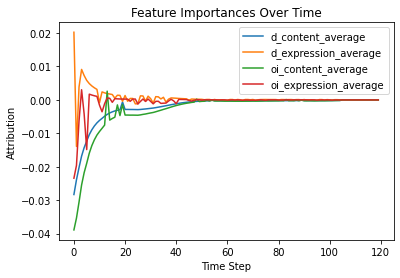

In [350]:
train_attention_model(X_train, X_test, y_train, y_test)

Attribution per Time Step: 
The IG method calculates the contribution of each feature at each time step towards the model's prediction. This enables to see not just which features are important, but also when they are important within the sequence.

A time step refers to one point in time in the input sequence. In the context of LSTM models, it's one cycle of processing by the LSTM unit. Is 120 LSTM default timestamp!?